## Importing the Microsoft Stocks Data

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

dataset_url = "https://www.kaggle.com/datasets/varpit94/microsoft-stock-data"
od.download_kaggle_dataset(dataset_url, data_dir='../')  # getting the dataset from kaggle

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: db333333
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/varpit94/microsoft-stock-data


100%|██████████| 182k/182k [00:00<00:00, 47.1MB/s]

## Data Exploration

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# reading the csv file (1987 - 2022)
microsoft_data = pd.read_csv("../microsoft-stock-data/MSFT.csv",
                            parse_dates=['Date'], index_col='Date')
microsoft_data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400
1986-03-20,0.098090,0.098090,0.094618,0.095486,0.060337,58435200
1986-03-21,0.095486,0.097222,0.091146,0.092882,0.058692,59990400
1986-03-24,0.092882,0.092882,0.089410,0.090278,0.057046,65289600
1986-03-25,0.090278,0.092014,0.089410,0.092014,0.058143,32083200


In [ ]:
training_size = 0.80
train_rows = int(len(microsoft_data) * training_size)

# split it into training and validation datasets
train_data = microsoft_data.iloc[:train_rows, :]
valid_data = microsoft_data.iloc[train_rows:, :]

In [ ]:
# changing Date from object to datetime
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7266 entries, 1986-03-13 to 2015-01-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       7266 non-null   float64
 1   High       7266 non-null   float64
 2   Low        7266 non-null   float64
 3   Close      7266 non-null   float64
 4   Adj Close  7266 non-null   float64
 5   Volume     7266 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 397.4 KB


In [ ]:
train_data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Open,7266.0,19.01,14.36,0.09,2.62,24.68,28.80,5.938000e+01
High,7266.0,19.24,14.53,0.09,2.66,25.00,29.11,5.997000e+01
Low,7266.0,18.78,14.18,0.09,2.58,24.40,28.47,5.856000e+01
Close,7266.0,19.01,14.36,0.09,2.62,24.68,28.80,5.956000e+01
Adj Close,7266.0,13.58,10.68,0.06,1.66,16.62,21.21,4.334000e+01
Volume,7266.0,65893659.26,39276685.78,2304000.00,43912400.00,58464150.00,78345800.00,1.031789e+09


In [ ]:
train_data.corr()['Open'].sort_values(ascending=False)

Open         1.000000
Low          0.999803
High         0.999801
Close        0.999598
Adj Close    0.979397
Volume      -0.109942
Name: Open, dtype: float64

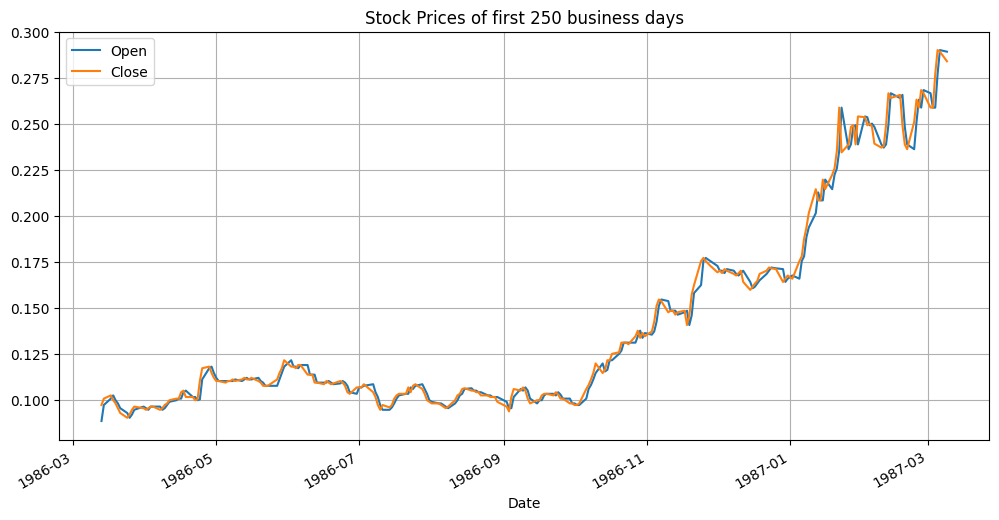

In [ ]:
days = 250
train_data.iloc[:days, :].plot(y=['Open', 'Close'],
                                title=f"Stock Prices of first {days} business days",
                                figsize=(12, 6), grid=True)
plt.show()

In [ ]:
train_data.shape

(7266, 6)

## Univariate Time Series Model

In [ ]:
# Get the open prices for training and validation
train_open_prices = train_data['Open'].to_numpy()
valid_open_prices = valid_data['Open'].to_numpy()

In [ ]:
# scaling the values
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# scale both X and y = scaler_x.fit_transform(X_train)
train_open_prices_scaled = scaler.fit_transform(train_open_prices.reshape(-1, 1))
valid_open_prices_scaled = scaler.transform(valid_open_prices.reshape(-1, 1))

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

TIME_STEPS = 250
BATCH_SIZE = 32

generator_train_obj = TimeseriesGenerator(train_open_prices_scaled, train_open_prices_scaled,
                                         TIME_STEPS, batch_size=BATCH_SIZE)

generator_valid_obj = TimeseriesGenerator(valid_open_prices_scaled, valid_open_prices_scaled,
                                         TIME_STEPS, batch_size=BATCH_SIZE)

In [ ]:
# X, y = generator_train_obj[0]
# X_val, y_val = generator_valid_obj[0]

# print("Training data:")
# print("\nscaled X:", X[0])
# print("\nscaled y:", y[:5])

# print("\n\nValidation Data:")
# print("\nscaled X:", X_val[0])
# print("\nscaled y:", y_val[:5])

In [ ]:
# buliding an LSTM model
from tensorflow import keras

keras.backend.clear_session() # clears the cache
early_stopping = keras.callbacks.EarlyStopping(patience=2) # early stopping for val_loss

model = keras.models.Sequential([
    keras.layers.LSTM(64, input_shape=(TIME_STEPS, 1), return_sequences=True),
    keras.layers.Dropout(0.15),
    keras.layers.LSTM(64),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(1, activation='relu'),
])

model.compile(loss="mse", optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 250, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the model with validation
history = model.fit(generator_train_obj, epochs=20,
                    validation_data=generator_valid_obj, callbacks=[early_stopping])

Epoch 1/20
220/220 [==============================] - 66s 283ms/step - loss: 0.0036 - val_loss: 1.5396
Epoch 2/20
220/220 [==============================] - 57s 261ms/step - loss: 0.0018 - val_loss: 1.3897
Epoch 3/20
220/220 [==============================] - 57s 257ms/step - loss: 0.0012 - val_loss: 0.9793
Epoch 4/20
220/220 [==============================] - 56s 253ms/step - loss: 0.0012 - val_loss: 0.5773
Epoch 5/20
220/220 [==============================] - 56s 255ms/step - loss: 0.0012 - val_loss: 0.5461
Epoch 6/20
220/220 [==============================] - 57s 258ms/step - loss: 9.7895e-04 - val_loss: 0.3326
Epoch 7/20
220/220 [==============================] - 58s 264ms/step - loss: 0.0012 - val_loss: 0.4607
Epoch 8/20
220/220 [==============================] - 56s 255ms/step - loss: 7.5123e-04 - val_loss: 0.3908


In [ ]:
y_train, y_valid = [], []
train_size = len(generator_train_obj)
valid_size = len(generator_valid_obj)

for i in range(train_size):
    _, y = generator_train_obj[i]
    y_train.extend(y.flatten())

for i in range(valid_size):
    _, y = generator_valid_obj[i]
    y_valid.extend(y.flatten())

y_train = np.array(y_train)
y_valid = np.array(y_valid)

y_train.shape, y_valid.shape

((7016,), (1567,))

In [ ]:
# Making predictions on Open prices
y_train_pred = model.predict(generator_train_obj)
y_valid_pred = model.predict(generator_valid_obj)

49/49 [==============================] - 3s 69ms/step


In [ ]:
from sklearn.metrics import mean_squared_error

print("Training loss:", mean_squared_error(y_train, y_train_pred))
print("Validation loss:", mean_squared_error(y_valid, y_valid_pred))

Training loss: 0.00033960076598591555
Validation loss: 0.3907601681372786


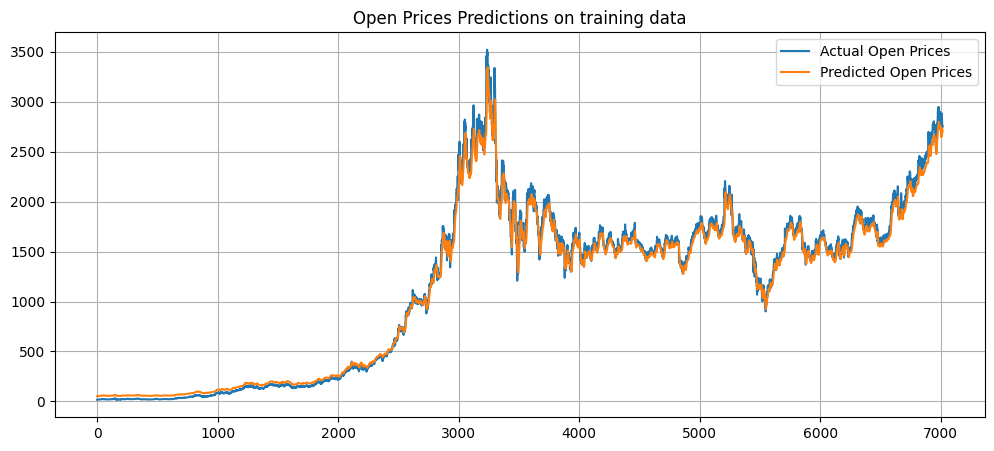

In [ ]:
# Plotting the training data predictions
time_steps = range(len(y_train))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred = scaler.inverse_transform(y_train_pred)

plt.figure(figsize=(12, 5))
plt.title("Open Prices Predictions on training data")
plt.plot(time_steps, y_train, label="Actual Open Prices")
plt.plot(time_steps, y_train_pred, label="Predicted Open Prices")
plt.grid(True)
plt.legend()
plt.show()

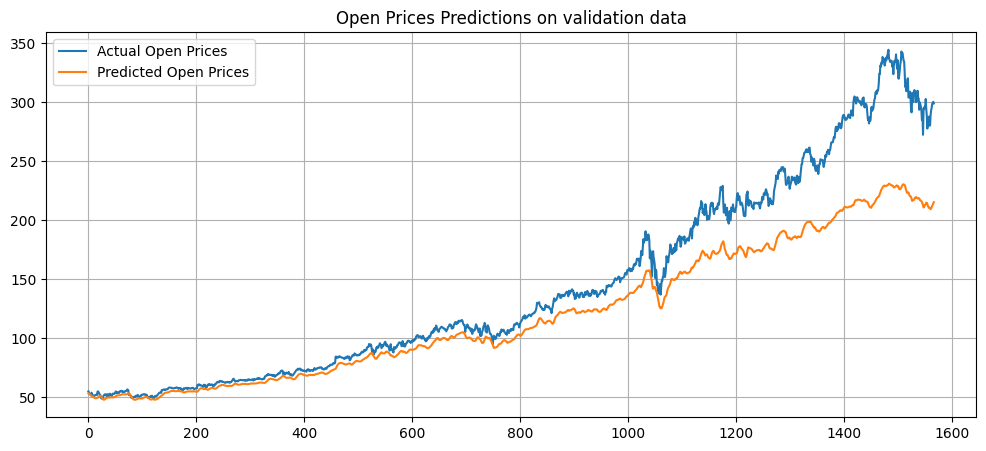

In [ ]:
# plotting the validation data predictions
time_steps = range(len(y_valid))
y_valid = scaler.inverse_transform(y_valid.reshape(-1, 1))
y_valid_pred = scaler.inverse_transform(y_valid_pred)

plt.figure(figsize=(12, 5))
plt.title("Open Prices Predictions on validation data")
plt.plot(time_steps, y_valid, label="Actual Open Prices")
plt.plot(time_steps, y_valid_pred, label="Predicted Open Prices")
plt.grid(True)
plt.legend()
plt.show()

## Multivariate Time Series Model

In [ ]:
train_data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400
1986-03-20,0.098090,0.098090,0.094618,0.095486,0.060337,58435200
1986-03-21,0.095486,0.097222,0.091146,0.092882,0.058692,59990400
1986-03-24,0.092882,0.092882,0.089410,0.090278,0.057046,65289600
1986-03-25,0.090278,0.092014,0.089410,0.092014,0.058143,32083200


In [ ]:
valid_data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-07,45.980000,46.459999,45.490002,46.230000,40.642883,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,41.838531,29645200
2015-01-09,47.610001,47.820000,46.900002,47.189999,41.486874,23944200
2015-01-12,47.419998,47.540001,46.360001,46.599998,40.968163,23651900
2015-01-13,46.970001,47.910000,46.060001,46.360001,40.757175,35270600
2015-01-14,45.959999,46.240002,45.619999,45.959999,40.405510,29719600
2015-01-15,46.220001,46.380001,45.410000,45.480000,39.983536,32750800
2015-01-16,45.310001,46.279999,45.169998,46.240002,40.651680,35695300
2015-01-20,46.299999,46.650002,45.570000,46.389999,40.783562,36161900


In [ ]:
# Preparing data for multivariate analysis
from sklearn.preprocessing import MinMaxScaler

features = train_data.iloc[:, 1:-1].to_numpy()
target = train_data.iloc[:, 0].to_numpy()

features_valid = valid_data.iloc[:, 1:-1].to_numpy()
target_valid = valid_data.iloc[:, 0].to_numpy()

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

features_valid_scaled = scaler_x.transform(features_valid)
target_valid_scaled = scaler_y.transform(target_valid.reshape(-1, 1))

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras

TIME_STEPS = 250
BATCH_SIZE = 32

generator_train_obj = TimeseriesGenerator(features_scaled, target_scaled,
                                          TIME_STEPS, batch_size=BATCH_SIZE)
generator_valid_obj = TimeseriesGenerator(features_valid_scaled, target_valid_scaled,
                                          TIME_STEPS, batch_size=BATCH_SIZE)

In [ ]:
X, y = generator_train_obj[0]

In [ ]:
X.shape, y.shape

((32, 250, 4), (32, 1))

In [ ]:
# from tensorflow import keras

# keras.backend.clear_session() # clear the cache

# early_stopping = keras.callbacks.EarlyStopping("val_loss", patience=1)

# # sequence to sequence RNN model
# rnn_model = keras.models.Sequential([
#     keras.layers.SimpleRNN(64, input_shape=(TIME_STEPS, 5), return_sequences=True),
#     keras.layers.Dropout(0.1),
#     keras.layers.SimpleRNN(64),
#     keras.layers.Dropout(0.1),
#     keras.layers.Dense(1, activation='relu')
# ])

# # compile and summarize the model
# rnn_model.compile(loss="mse", optimizer="adam")
# rnn_model.summary()

In [ ]:
# Creating an LSTM model
keras.backend.clear_session()

early_stopping = keras.callbacks.EarlyStopping("val_loss", patience=2)

lstm_model = keras.models.Sequential([
    keras.layers.LSTM(64, input_shape=(TIME_STEPS, 4), return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='relu')
])

lstm_model.compile(loss="mse", optimizer='adam')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 64)           17664     
                                                                 
 dropout (Dropout)           (None, 250, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 50753 (198.25 KB)
Trainable params: 50753 (198.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the model
EPOCHS = 20

# history = rnn_model.fit(generator_train_obj, validation_data=generator_valid_obj,
#                     epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

history = lstm_model.fit(generator_train_obj, validation_data=generator_valid_obj,
                    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/20
220/220 [==============================] - 65s 279ms/step - loss: 0.0219 - val_loss: 2.1696
Epoch 2/20
220/220 [==============================] - 60s 273ms/step - loss: 0.0020 - val_loss: 2.5049
Epoch 3/20
220/220 [==============================] - 62s 282ms/step - loss: 0.0018 - val_loss: 1.7723
Epoch 4/20
220/220 [==============================] - 60s 273ms/step - loss: 0.0014 - val_loss: 1.6325
Epoch 5/20
220/220 [==============================] - 61s 276ms/step - loss: 0.0014 - val_loss: 1.3402
Epoch 6/20
220/220 [==============================] - 57s 261ms/step - loss: 0.0014 - val_loss: 1.5853
Epoch 7/20
220/220 [==============================] - 56s 257ms/step - loss: 0.0010 - val_loss: 1.1851
Epoch 8/20
220/220 [==============================] - 58s 265ms/step - loss: 8.2316e-04 - val_loss: 1.3721
Epoch 9/20
220/220 [==============================] - 58s 261ms/step - loss: 9.9904e-04 - val_loss: 1.3136


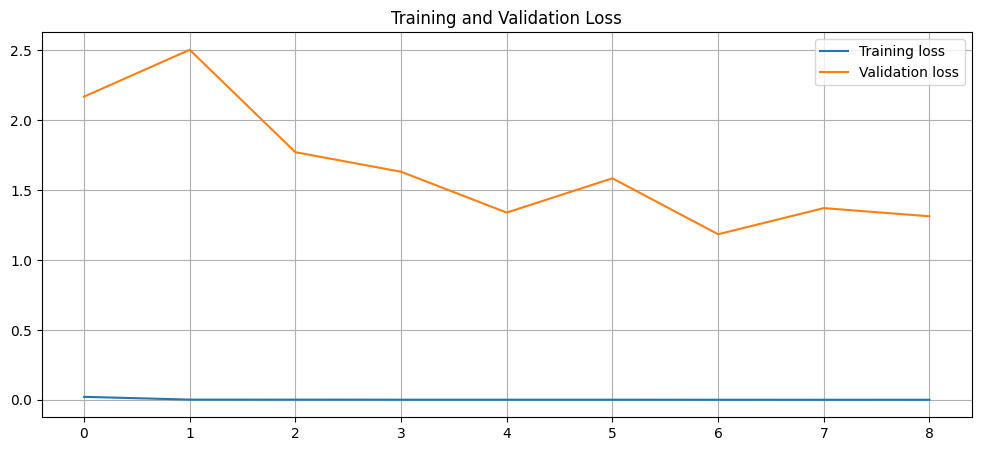

In [ ]:
epochs = history.epoch

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.title("Training and Validation Loss")
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
y_train_pred = lstm_model.predict(generator_train_obj, batch_size=BATCH_SIZE)
y_valid_pred = lstm_model.predict(generator_valid_obj, batch_size=BATCH_SIZE)

49/49 [==============================] - 3s 64ms/step


In [ ]:
y_train_vals, y_valid_vals = [], []
train_size = len(generator_train_obj)
valid_size = len(generator_valid_obj)

for i in range(train_size):
    _, y = generator_train_obj[i]
    y_train_vals.extend(y.flatten())

for i in range(valid_size):
    _, y = generator_valid_obj[i]
    y_valid_vals.extend(y.flatten())

y_train_vals = np.array(y_train_vals).reshape(-1, 1)
y_valid_vals = np.array(y_valid_vals).reshape(-1, 1)

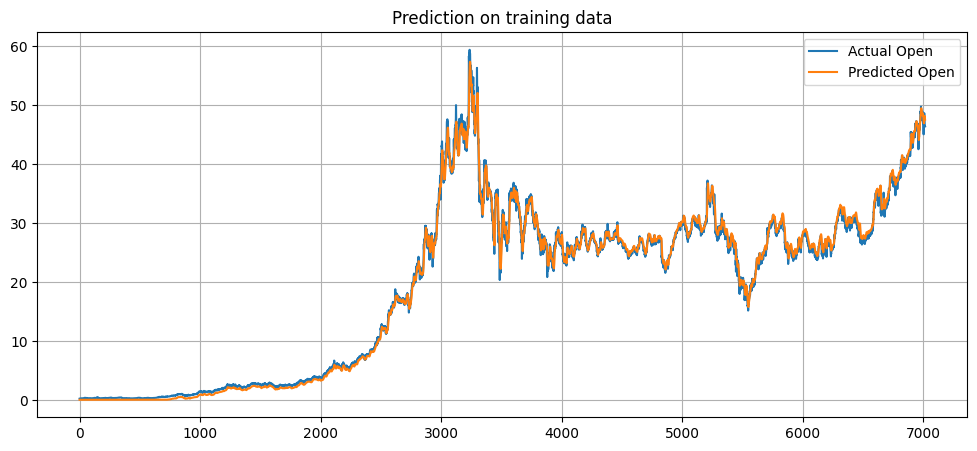

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("Prediction on training data")
plt.plot(scaler_y.inverse_transform(y_train_vals), label="Actual Open")
plt.plot(scaler_y.inverse_transform(y_train_pred), label="Predicted Open")
plt.grid(True)
plt.legend()
plt.show()

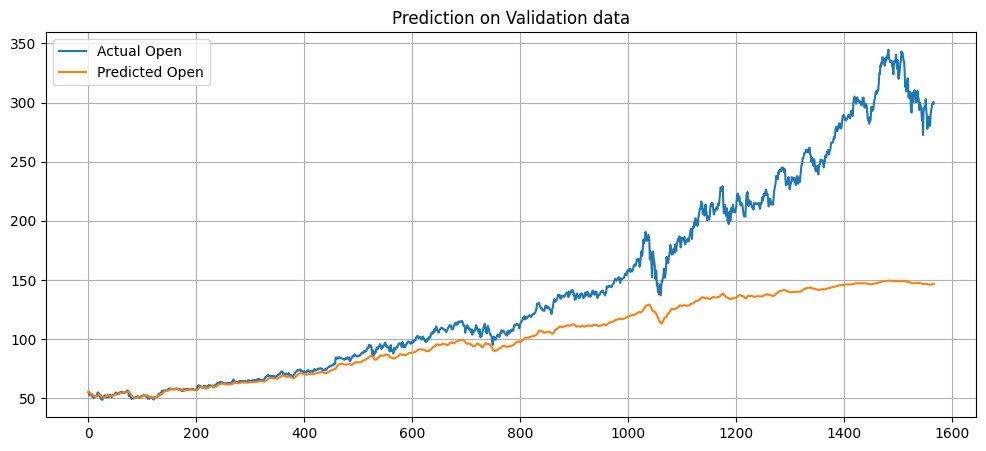

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("Prediction on Validation data")
plt.plot(scaler_y.inverse_transform(y_valid_vals), label="Actual Open")
plt.plot(scaler_y.inverse_transform(y_valid_pred), label="Predicted Open")
plt.grid(True)
plt.legend()
plt.show()